## Assigment by Talib 

In [25]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [3]:
data = pd.read_csv('Fraud.csv',sep=',')
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [4]:
from sklearn.preprocessing import LabelEncoder;
lb=LabelEncoder()
data['type']=lb.fit_transform(data['type'])
data=data.drop(['nameOrig','nameDest'],axis=1)
data.head(10)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,170136.00,160296.36,0.0,0.00,0,0
1,1,3,1864.28,21249.00,19384.72,0.0,0.00,0,0
2,1,4,181.00,181.00,0.00,0.0,0.00,1,0
3,1,1,181.00,181.00,0.00,21182.0,0.00,1,0
4,1,3,11668.14,41554.00,29885.86,0.0,0.00,0,0
5,1,3,7817.71,53860.00,46042.29,0.0,0.00,0,0
6,1,3,7107.77,183195.00,176087.23,0.0,0.00,0,0
7,1,3,7861.64,176087.23,168225.59,0.0,0.00,0,0
8,1,3,4024.36,2671.00,0.00,0.0,0.00,0,0
9,1,2,5337.77,41720.00,36382.23,41898.0,40348.79,0,0


In [32]:
data.info()
data['isFlaggedFraud'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
 8   isFlaggedFraud  int64  
dtypes: float64(5), int32(1), int64(3)
memory usage: 412.6 MB


isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

## Exploratory Data Analysis

In [6]:
## Get the Fraud and the normal dataset 

fraud = data[data['isFraud']==1]

normal = data[data['isFraud']==0]

In [7]:
print(fraud.shape,normal.shape)

(8213, 9) (6354407, 9)


In [8]:
fraud.amount.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

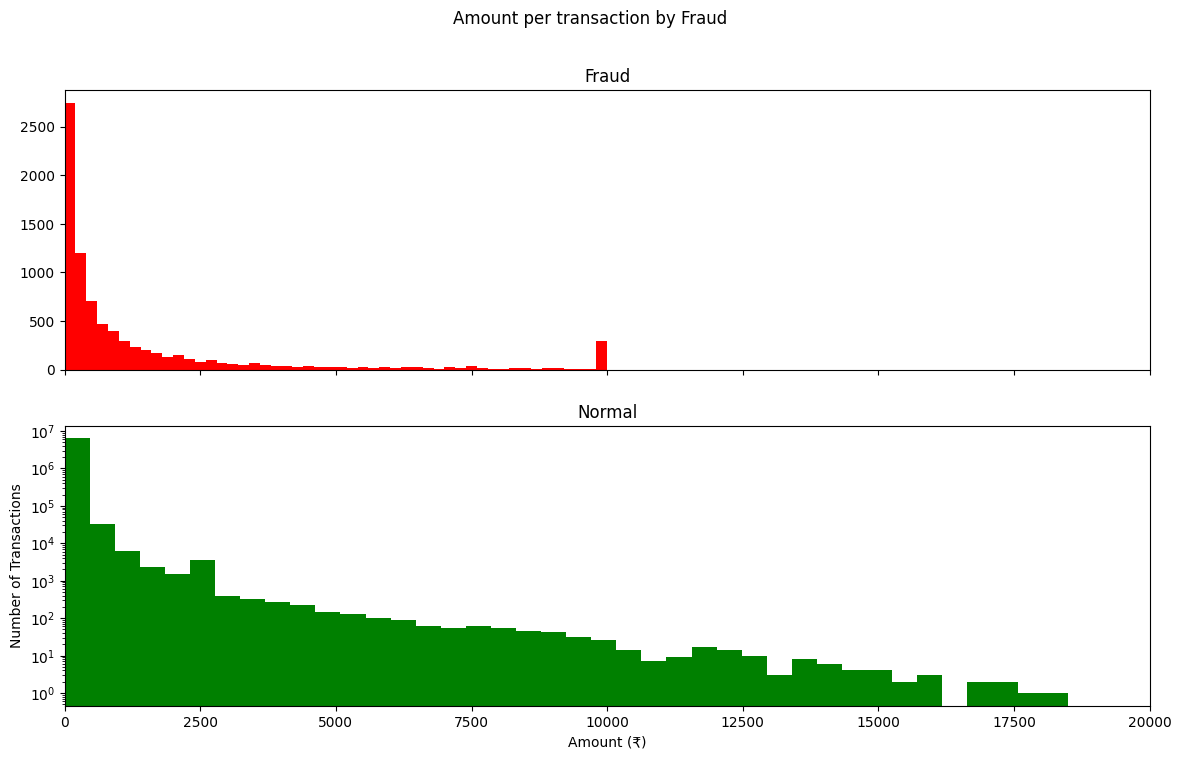

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by Fraud')
bins = 50

# Update the color for the histograms
ax1.hist(fraud.amount / 1000, bins=bins, color='red')  # Fraud transactions in red
ax1.set_title('Fraud')

ax2.hist(normal.amount / 4000, bins=bins, color='green')  # Normal transactions in green
ax2.set_title('Normal')

plt.xlabel('Amount (₹)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()


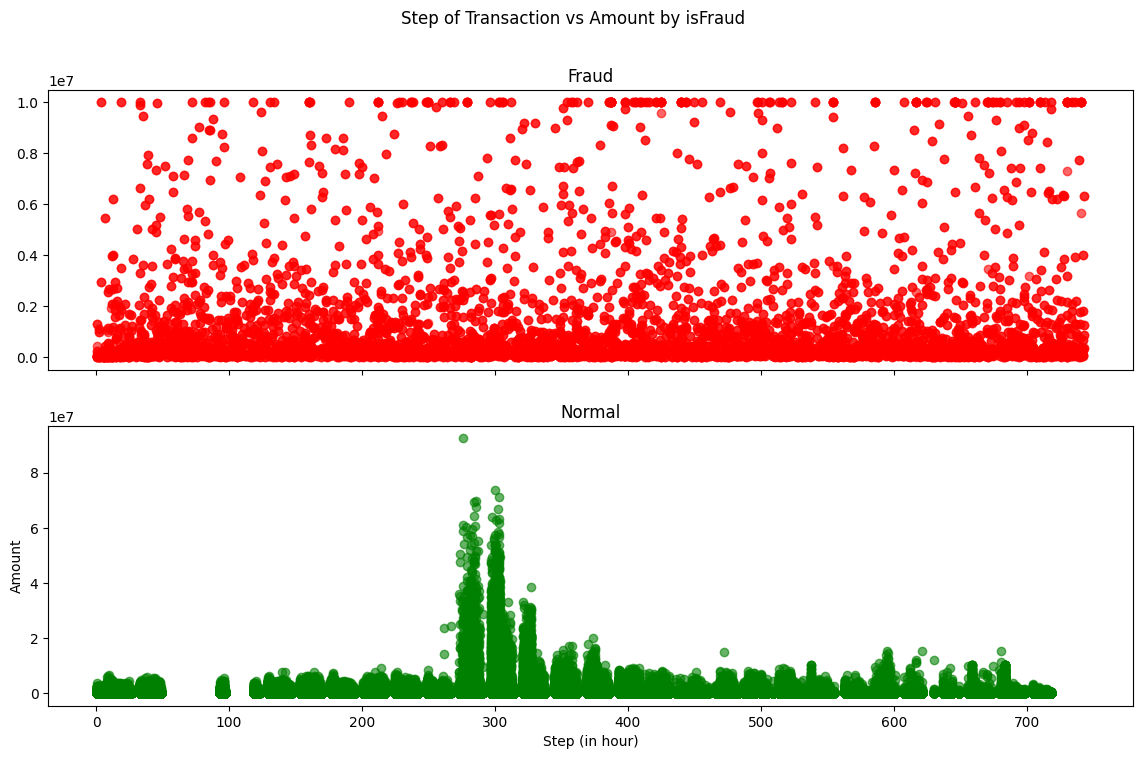

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Step of Transaction vs Amount by isFraud')

# Change the color of the scatter plots
ax1.scatter(fraud.step, fraud.amount, color='red', alpha=0.6)  # Fraud transactions in red
ax1.set_title('Fraud')

ax2.scatter(normal.step, normal.amount, color='green', alpha=0.6)  # Normal transactions in green
ax2.set_title('Normal')

plt.xlabel('Step (in hour)')
plt.ylabel('Amount')
plt.show()


In [11]:
data1= data.sample(frac = 0.1,random_state=1)

data1.shape

(636262, 9)

In [12]:
Fraud = data1[data1['isFraud']==1]

Valid = data1[data1['isFraud']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [13]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0012888646188564514
Fraud Cases : 819
Valid Cases : 635443


<Figure size 1000x1200 with 0 Axes>

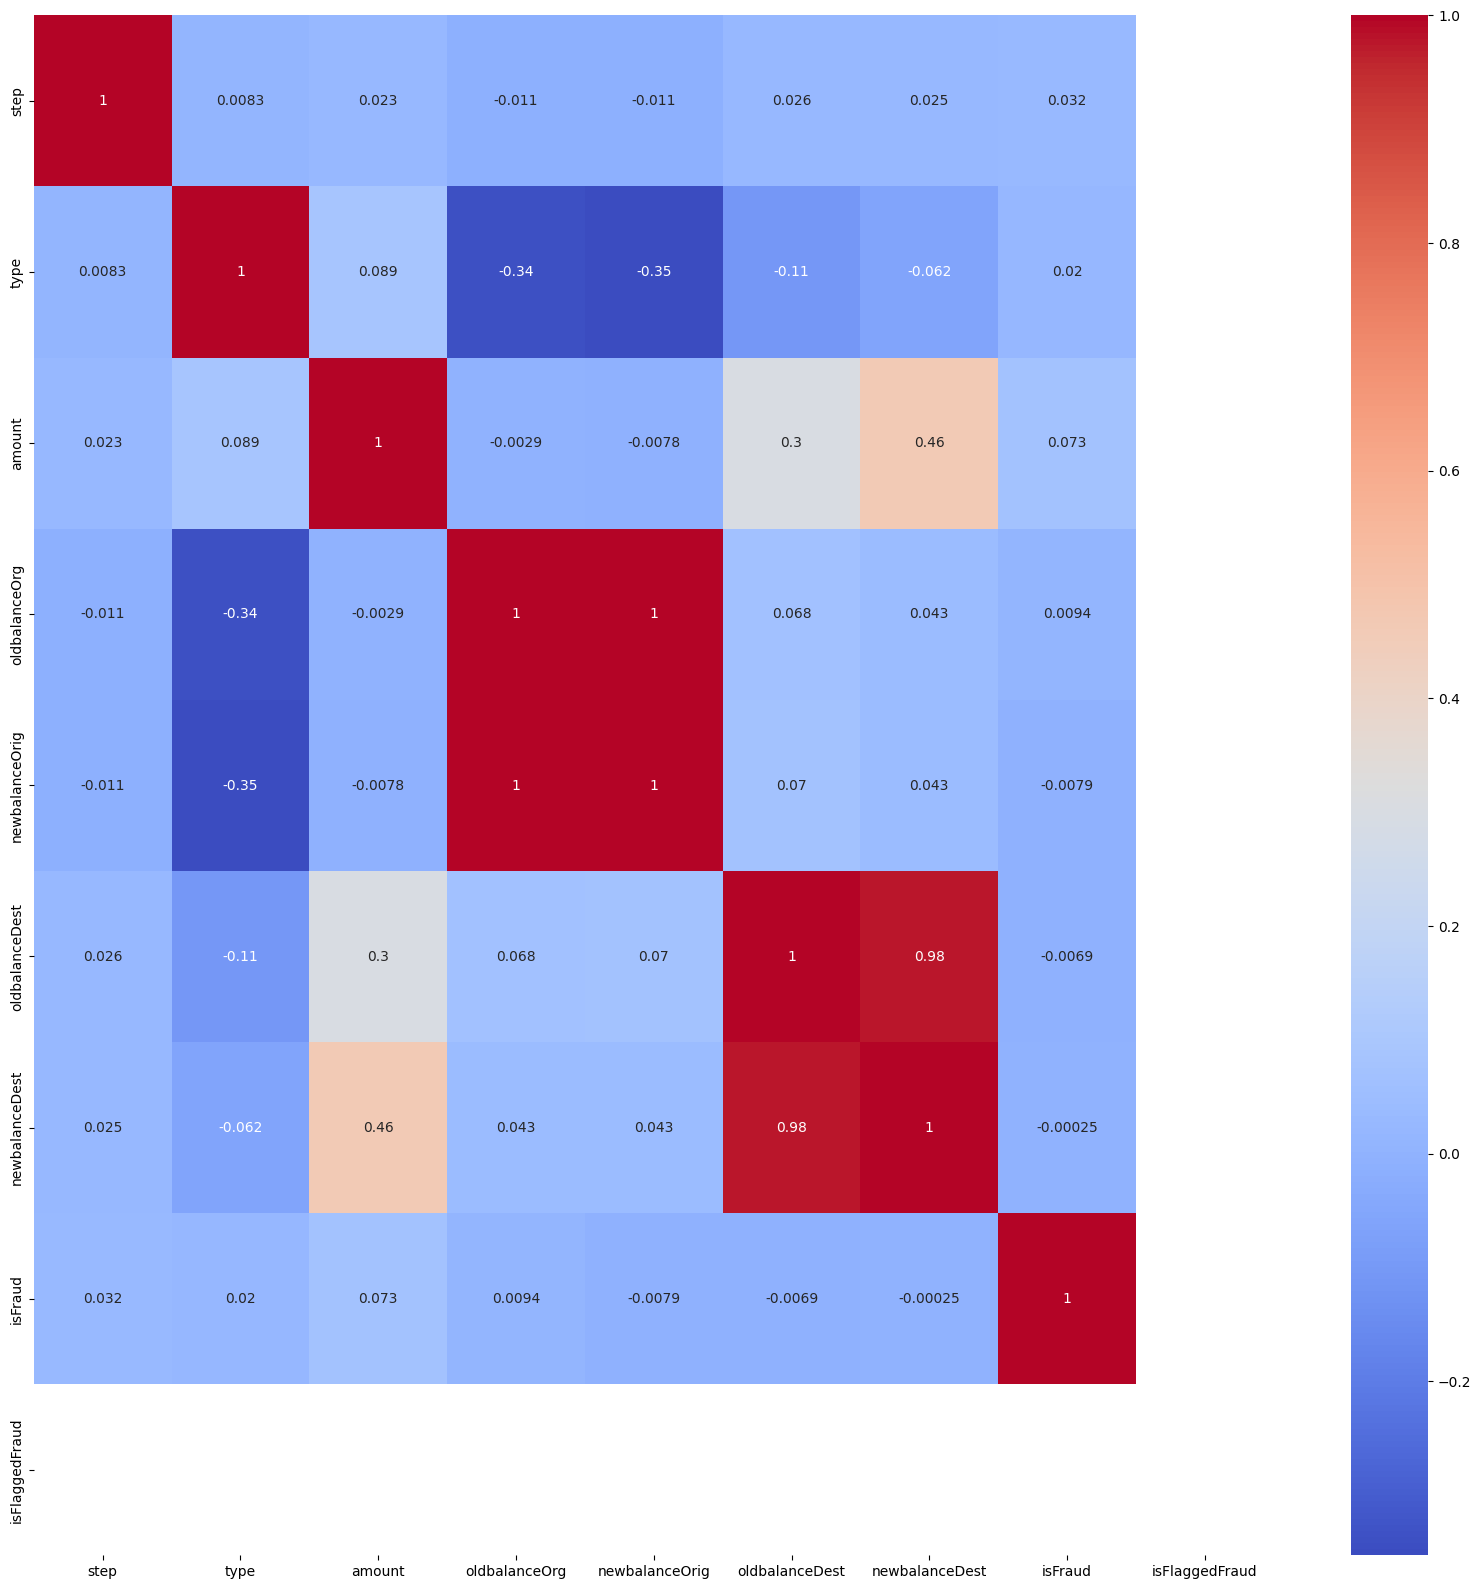

In [14]:
## Correlation
plt.figure(figsize=(10, 12))
import seaborn as sns

# Get correlations of each feature in the dataset
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 20))

# Plot heatmap with a new colormap
g = sns.heatmap(data1[top_corr_features].corr(), annot=True, cmap="coolwarm")  # Using 'coolwarm' as the colormap


In [15]:
state = np.random.RandomState(42)
X=data[['step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFlaggedFraud']]
Y=data['isFraud']
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
print(X.shape)
print(Y.shape)

(6362620, 8)
(6362620,)


In [16]:
X.head(10)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,1,3,9839.64,170136.00,160296.36,0.0,0.00,0
1,1,3,1864.28,21249.00,19384.72,0.0,0.00,0
2,1,4,181.00,181.00,0.00,0.0,0.00,0
3,1,1,181.00,181.00,0.00,21182.0,0.00,0
4,1,3,11668.14,41554.00,29885.86,0.0,0.00,0
5,1,3,7817.71,53860.00,46042.29,0.0,0.00,0
6,1,3,7107.77,183195.00,176087.23,0.0,0.00,0
7,1,3,7861.64,176087.23,168225.59,0.0,0.00,0
8,1,3,4024.36,2671.00,0.00,0.0,0.00,0
9,1,2,5337.77,41720.00,36382.23,41898.0,40348.79,0


In [17]:
from sklearn.model_selection import train_test_split
x=X.sample(frac = 0.0001,random_state=1)
y=Y.sample(frac = 1.0,random_state=1)
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.2)

In [18]:
print(x_train.size)
print(x_test.size)

4072072
1018024


## Model Prediction





Now it is time to start building the model .The types of algorithms I am going to use to try to do anomaly detection on this dataset are as follows

### Isolation Forest Algorithm :
One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Work
The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.


### Local Outlier Factor(LOF) Algorithm
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_train)  # Scaling training data
X2_scaled = scaler.transform(x_test)      # Scaling test data (IMPORTANT!)

# Train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X_scaled, y_train, test_size=0.2, random_state=42)

# Define the model
model = Sequential()

# Input layer + First hidden layer
model.add(Dense(128, input_dim=X2_train.shape[1], activation='relu'))  
model.add(Dropout(0.3))  # Dropout layer to prevent overfitting

# Second hidden layer
model.add(Dense(64, activation='relu'))  
model.add(Dropout(0.3))

# Third hidden layer (Optional, for deeper architecture)
model.add(Dense(32, activation='relu'))  
model.add(Dropout(0.3))

# Output layer with softmax (3 classes)
model.add(Dense(3, activation='softmax'))

# Compile the model with a learning rate scheduler
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X2_train, y2_train, epochs=15, batch_size=32, validation_data=(X2_test, y2_test), callbacks=[early_stopping])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X2_test, y2_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Additional evaluation metrics
y2_pred = model.predict(X2_test)
y2_pred_classes = np.argmax(y2_pred, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y2_test, y2_pred_classes))

Epoch 1/15


C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12726/12726 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9964 - loss: 0.0211 - val_accuracy: 0.9990 - val_loss: 0.0061
Epoch 2/15
12726/12726 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9991 - loss: 0.0061 - val_accuracy: 0.9990 - val_loss: 0.0059
Epoch 3/15
12726/12726 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9991 - loss: 0.0055 - val_accuracy: 0.9990 - val_loss: 0.0056
Epoch 4/15
12726/12726 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9992 - loss: 0.0053 - val_accuracy: 0.9991 - val_loss: 0.0046
Epoch 5/15
12726/12726 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9992 - loss: 0.0047 - val_accuracy: 0.9991 - val_loss: 0.0076
Epoch 6/15
12726/12726 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9992 - loss: 0.0054 - val_accuracy: 0.9992 - val_loss: 0.0040
Epoch 7/15
12726/12726 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9992 - loss: 0.0055 - val_accuracy: 0.9991 - val_loss: 0.0045
Epoch 8/15
12726/12726 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9992 - lo

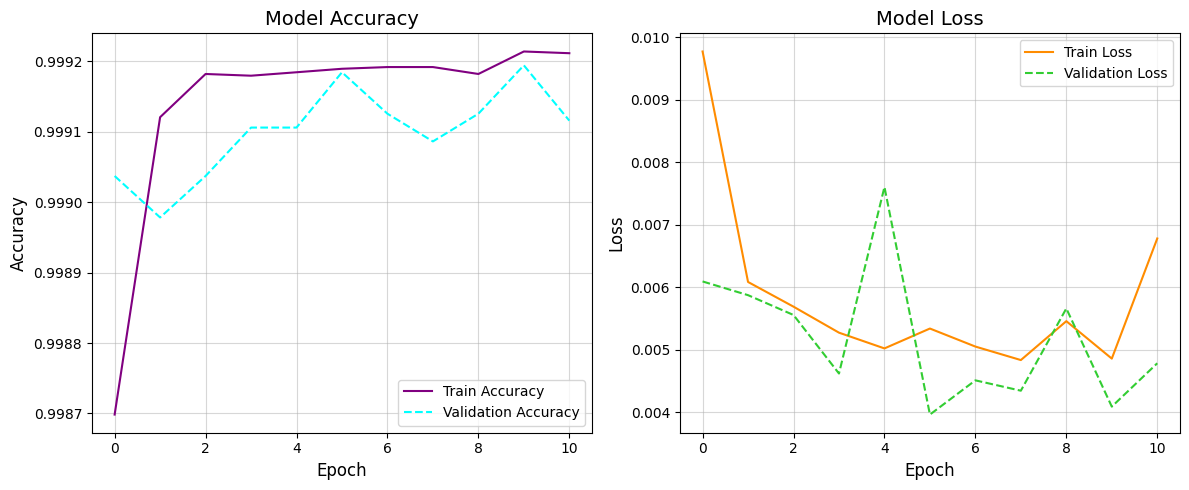

In [27]:
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='purple', linestyle='-')  # Changed to purple
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan', linestyle='--')  # Changed to cyan
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.5)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='darkorange', linestyle='-')  # Changed to dark orange
plt.plot(history.history['val_loss'], label='Validation Loss', color='limegreen', linestyle='--')  # Changed to lime green
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.5)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [29]:
model.save('Model_Fraud.h5')

In [33]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

Accuracy: 0.9781
Predictions (0: normal, 1: anomaly):
[0 0 0 ... 1 1 1]


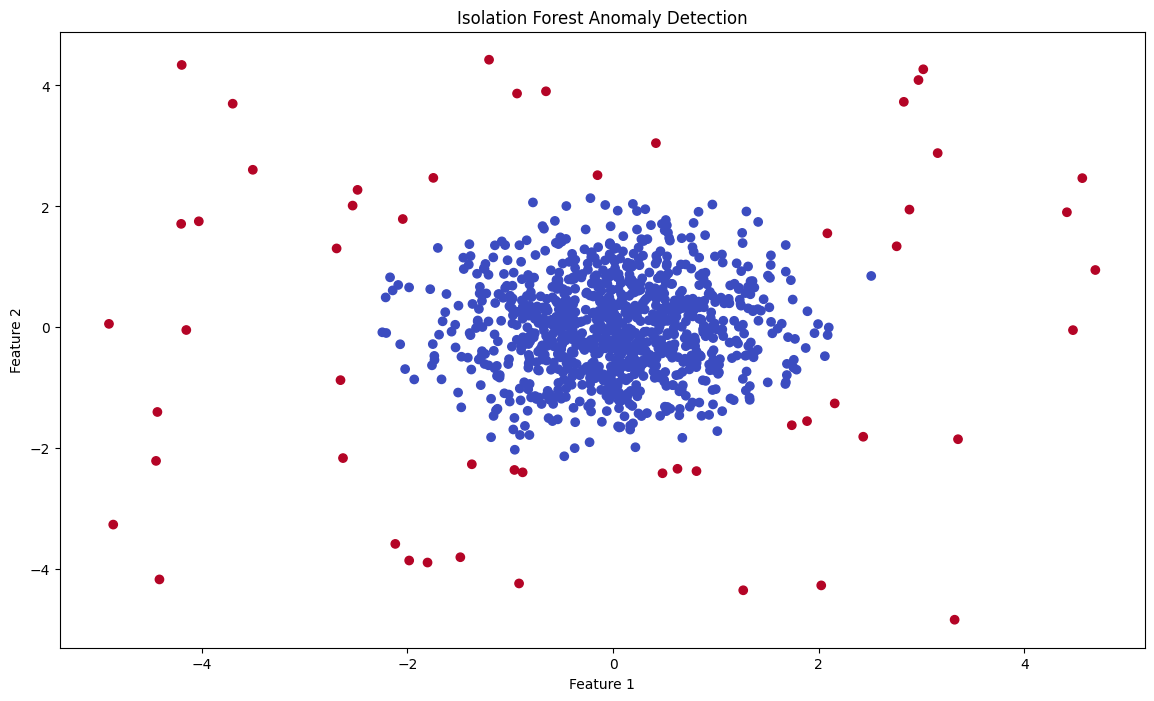

In [41]:
# True labels: 0 for normal, 1 for outliers
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X2_train)

# Train Isolation Forest model
model1 = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model1.fit(X_train_scaled)

# Predict anomalies (1 for normal, -1 for outliers)
y_pred = model1.predict(X_train_scaled)

# Convert predictions to binary labels (0 for normal, 1 for anomaly)
y_pred = np.where(y_pred == 1, 0, 1)  # 1 -> normal (0), -1 -> anomaly (1)

# Calculate accuracy
accuracy = accuracy_score(y2_test, y_pred)

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")

# Display predicted labels
print("Predictions (0: normal, 1: anomaly):")
print(y_pred)

# Optionally, plot the data to visualize anomalies
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_pred, cmap='coolwarm')
plt.title("Isolation Forest Anomaly Detection")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [37]:
pip install joblib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
import joblib

# Save the model to a file
joblib.dump(model, 'isolation_forest_model.pkl')

['isolation_forest_model.pkl']

#### Observations :
- Isolation Forest detected 33 errors versus Local Outlier Factor detecting 27 errors vs.
- Isolation Forest has a 0.9978783592644979 accurate and LOF of 0.9978783592644979 and SVM of 70.09
- When comparing error precision & recall for 3 models , the LOF performed better than the Isolation Forestas.
- So overall Isolation Forest and LOF Method performed much better in determining the fraud cases.
- We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases